# DSE Course 2, Session 6: Product Quality Case Study Part 2

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will continue with our wine quality prediction model from Course 1. We will apply strategies to improve our model in light of  colinearity between features and feature skewness.

<br>

---

<br>

<a name='top'></a>

# Contents

* 6.0 [Preparing Environment and Importing Data](#x.0)
  * 6.0.1 [Import Packages](#x.0.1)
  * 6.0.2 [Load Dataset](#x.0.2)
* 6.1 [Feature Engineering](#x.1)
  * 6.1.1 [Feature Skewness](#x.1.1)
  * 6.1.2 [Feature Colinearity](#x.1.2)
  * 6.1.3 [Feature Normalization](#x.1.3)
  * 6.1.4 [Feature Selection](#x.1.4)
  * 6.1.5 [Dimensionality Reduction](#x.1.5)
* 6.2 [Modeling](#x.2)
  * 6.2.1 [Models from Course 1](#x.2.1)
  * 6.2.2 [Random Forests](#x.2.2)
  * 6.2.3 [Support Vector Machine](#x.2.3)
  * 6.2.4 [Gradient Boosting](#x.2.4)
  * 6.2.5 [AdaBoost](#x.2.5)
  * 6.2.6 [XGBoost](#x.2.6)
  

<br>

---

<a name='x.0'></a>

## 6.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>
### 6.0.1 Import Packages
[back to top](#top)

Load libraries which will be needed in this Notebook



In [ ]:
# Pandas library for the pandas dataframes
from copy import copy
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import seaborn as sns
import plotly.express as px
import random
import scipy.stats as stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



<a name='x.0.2'></a>
### 6.0.2 Load Dataset
[back to top](#top)


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

# for some packages we will want to remove spaces in the header names
df.columns = df.columns.str.replace(' ', '_')

# the quality label will be a made up target for us to predict
df['quality_label'] = df['quality'].apply(lambda x: 'low' if x <=5 else 
                                          'med' if x <= 7 else 'high')

class_tp = {'red': 0, 'white': 1}
y_tp = df['type'].map(class_tp)
df['type_encoding'] = y_tp

class_ql = {'low':0, 'med': 1, 'high': 2}
y_ql = df['quality_label'].map(class_ql)
df['quality_encoding'] = y_ql

features = list(df.columns[1:-1].values)

# features.remove('type_encoding')
features.remove('quality_label')
features.remove('quality')

<a name='x.0.2'></a>
### 6.0.2 Base Model
[back to top](#top)


In [ ]:
df_base = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_base.loc[:, features + 
                                      ['type_encoding']], df_base['quality_label'],
                                      test_size=0.20, random_state=42)
model = LogisticRegression(penalty='l2',
                           tol=.001,
                           C=.003,
                           class_weight='balanced',
                           solver='sag',
                           max_iter=1e6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score
                                   (y_test, y_pred)))
print('Precision: {:2.2%} '.format(metrics.precision_score
                                   (y_test, y_pred, average='weighted')))
print('Recall:    {:2.2%} '.format(metrics.recall_score
                                   (y_test, y_pred, average='weighted')))
print('F1 Score:  {:2.2%} '.format(metrics.f1_score
                                   (y_test, y_pred, average='weighted')))

Accuracy:  41.14% 
Precision: 58.69% 
Recall:    41.14% 
F1 Score:  42.86% 


<a name='x.1'></a>

## 6.1 Feature Engineering

[back to top](#top)

<a name='x.1.0'></a>

### 6.1.1 Missing Data

[back to top](#top)

In [ ]:
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(df[features])
df_impute = pd.DataFrame(X2, columns=features)
print(df_impute.shape)
df_impute.head()

(6497, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1.0


<a name='x.1.1'></a>

### 6.1.1 Feature Skewness

[back to top](#top)

In [ ]:
df_impute.skew()

fixed_acidity           1.724131
volatile_acidity        1.496433
citric_acid             0.473142
residual_sugar          1.435221
chlorides               5.400680
free_sulfur_dioxide     1.220066
total_sulfur_dioxide   -0.001177
density                 0.503602
pH                      0.387234
sulphates               1.799021
alcohol                 0.565718
type_encoding          -1.179095
dtype: float64

In [ ]:
df_impute.kurtosis()

fixed_acidity            5.070143
volatile_acidity         2.834263
citric_acid              2.404077
residual_sugar           4.360399
chlorides               50.911457
free_sulfur_dioxide      7.906238
total_sulfur_dioxide    -0.371664
density                  6.606067
pH                       0.374743
sulphates                8.667071
alcohol                 -0.531687
type_encoding           -0.609922
dtype: float64

<a name='x.1.2'></a>

### 6.1.2 Feature Colinearity

[back to top](#top)

In [ ]:
def VIF(df, features):
  # add intercept for OLS in statmodels
  X = df[features].assign(constant=1)

  # Calculate VIF Factors
  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in 
                        range(X.shape[1])]
  vif["features"] = X.columns
  return vif.iloc[:-1].sort_values("VIF Factor") # here I've omitted the intercept

In [ ]:
VIF(df_impute, features)

,VIF Factor,features
9,1.553300,sulphates
2,1.620286,citric_acid
4,1.658053,chlorides
1,2.164411,volatile_acidity
5,2.236447,free_sulfur_dioxide
8,2.544397,pH
6,4.044881,total_sulfur_dioxide
0,5.008898,fixed_acidity
10,5.586239,alcohol
11,7.219469,type_encoding


<a name='x.1.3'></a>

### 6.1.3 Feature Normalization

[back to top](#top)

We can first try the standard scaler in sklearn, to scale to 0 mean and unit variance:

In [ ]:
scaler = StandardScaler()
normed = scaler.fit_transform(df_impute)
df_normed = pd.DataFrame(normed, columns=features)
df_normed.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding
0,-0.167159,-0.423564,0.284245,3.206977,-0.315222,0.815565,0.959976,2.102214,-1.359665,-0.545959,-1.418558,0.571367
1,-0.707427,-0.241232,0.146523,-0.808136,-0.201027,-0.931107,0.287618,-0.232332,0.508045,-0.277064,-0.831615,0.571367
2,0.681835,-0.362786,0.559689,0.306005,-0.172479,-0.029599,-0.331660,0.134525,0.259017,-0.613183,-0.328521,0.571367
3,-0.012796,-0.666673,0.008801,0.642350,0.055911,0.928254,1.243074,0.301278,-0.176782,-0.882078,-0.496219,0.571367
4,-0.012796,-0.666673,0.008801,0.642350,0.055911,0.928254,1.243074,0.301278,-0.176782,-0.882078,-0.496219,0.571367


We note that this doesn't effect skew or kurtosis:

In [ ]:
pd.DataFrame([df_normed.kurtosis(), df[features].kurtosis(),
              df_normed.skew(), df[features].skew()],
             index=pd.MultiIndex(levels=[['normalized', 'original'],
                                         ['kurtosis', 'skew']],
              codes=[[0,1,0,1],[0,0,1,1]]))

,,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_encoding
normalized,kurtosis,5.070143,2.834263,2.404077,4.360399,50.911457,7.906238,-0.371664,6.606067,0.374743,8.667071,-0.531687,-0.609922
original,kurtosis,5.057727,2.827081,2.401582,4.358134,50.894874,7.906238,-0.371664,6.606067,0.370068,8.659892,-0.531687,-0.609922
normalized,skew,1.724131,1.496433,0.473142,1.435221,5.400680,1.220066,-0.001177,0.503602,0.387234,1.799021,0.565718,-1.179095
original,skew,1.722805,1.495512,0.473032,1.435000,5.399849,1.220066,-0.001177,0.503602,0.386966,1.798467,0.565718,-1.179095


We can use, instead, the box-cox transformation method to remove skew and kurtosis from the data:

In [ ]:
pt_scaler = PowerTransformer(method='box-cox', standardize=False)

# box-cox only works with strictly positive data
box_features = [i for i,j in (df_impute[features] > 0).all().items() if j]
normed = pt_scaler.fit_transform(df_impute[box_features])
df_box = pd.DataFrame(normed, columns=box_features)
df_box.head()

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.704710,-1.581363,2.315374,-6.995612,10.327309,94.987311,0.000988,0.542653,-0.964717,0.540552
1,0.695841,-1.431601,0.450013,-6.638334,5.138100,76.194892,-0.006470,0.560131,-0.844178,0.541934
2,0.715142,-1.529169,1.622166,-6.555646,8.203181,58.196623,-0.005210,0.558030,-0.997321,0.542910
3,0.706882,-1.817921,1.764890,-5.971609,10.579487,102.716352,-0.004649,0.554195,-1.139405,0.542603
4,0.706882,-1.817921,1.764890,-5.971609,10.579487,102.716352,-0.004649,0.554195,-1.139405,0.542603


In [ ]:
pd.DataFrame([df_box.kurtosis(), df[features].kurtosis(),
              df_box.skew(), df[features].skew()],
             index=pd.MultiIndex(levels=[['boxcox', 'original'],['kurtosis', 'skew']],
              codes=[[0,1,0,1],[0,0,1,1]]))

,,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,citric_acid,type_encoding
boxcox,kurtosis,1.157554,-0.208453,-1.270111,1.078939,-0.087744,-0.457496,0.322114,0.034553,0.167344,-0.973330,NaN,NaN
original,kurtosis,5.057727,2.827081,4.358134,50.894874,7.906238,-0.371664,6.606067,0.370068,8.659892,-0.531687,2.401582,-0.609922
boxcox,skew,-0.063260,0.010663,0.069394,-0.058053,-0.040868,-0.179761,-0.020815,-0.000908,-0.007615,0.067033,NaN,NaN
original,skew,1.722805,1.495512,1.435000,5.399849,1.220066,-0.001177,0.503602,0.386966,1.798467,0.565718,0.473032,-1.179095


<a name='x.1.4'></a>

### 6.1.4 Feature Selection

[back to top](#top)

One feature we might consider removing is density, since it has such a high VIF

<a name='x.1.5'></a>

### 6.1.5 Dimensionality Reduction

[back to top](#top)

We choose a meaningful number of principal components

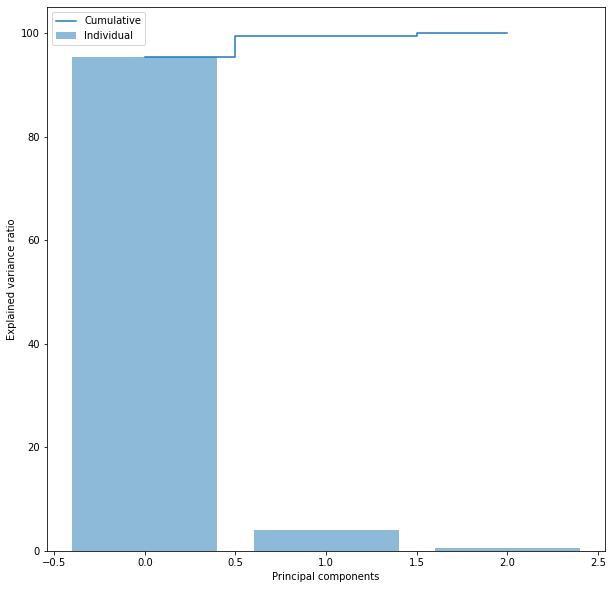

In [ ]:
comp = 3
pca = PCA(n_components=comp)
X_pca = pca.fit_transform(pd.merge(df_impute.loc[:,features],df['type_encoding'], left_index=True, 
    right_index=True))

tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.bar(range(comp), var_exp, alpha=0.5, align='center',
        label='Individual')
ax.step(range(comp), cum_var_exp, where='mid',
          label='Cumulative')

ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal components')
ax.legend()

<a name='x.2'></a>

## 6.2 Modeling

[back to top](#top)

<a name='x.2.1'></a>

### 6.2.1 Models from Course 1

[back to top](#top)

In [ ]:
# create train/test indices so that we can apply these to the different datasets
Xid_train, Xid_test, yid_train, yid_test = train_test_split(
    range(df.shape[0]), range(df.shape[0]), random_state=42)

In [ ]:
# and define the function to standardize our model testing
def train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X, y, 
                     verbose=True):
  
  X_train = X.iloc[Xid_train]
  X_test = X.iloc[Xid_test]
  y_train = y.iloc[yid_train]
  y_test = y.iloc[yid_test]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  acc = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred, average='weighted')
  recall = metrics.recall_score(y_test, y_pred, average='weighted')
  f1 = metrics.f1_score(y_test, y_pred, average='weighted')

  if verbose:
    print('Accuracy:  {:2.2%} '.format(acc))
    print('Precision: {:2.2%} '.format(precision))
    print('Recall:    {:2.2%} '.format(recall))
    print('F1 Score:  {:2.2%} '.format(f1))

  return acc, precision, recall, f1

#### 6.2.1.1 With Imputed Data

In [ ]:
model = LogisticRegression(penalty='l2',
                           tol=.001,
                           C=.003,
                           class_weight='balanced',
                           solver='sag',
                           max_iter=1e6)

In [ ]:
X_imp = pd.merge(df_impute.loc[:,features],df['type_encoding'], left_index=True, 
    right_index=True)

In [ ]:
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_imp, y_ql)

Accuracy:  40.18% 
Precision: 58.55% 
Recall:    40.18% 
F1 Score:  41.15% 


#### 6.2.1.2 With Box-Cox Transformed Data

In [ ]:
X_box = pd.merge(df_box.loc[:,box_features],df_impute[['type_encoding', 
                 'citric_acid']], left_index=True, right_index=True)

In [ ]:
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_box, y_ql)

Accuracy:  40.06% 
Precision: 62.69% 
Recall:    40.06% 
F1 Score:  43.33% 


#### 6.2.1.3 With Zero-Mean and Unit Variance Data

In [ ]:
X_norm = pd.merge(df_normed.loc[:,features],df['type_encoding'], left_index=True, 
    right_index=True)

In [ ]:
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_norm, y_ql)

Accuracy:  49.17% 
Precision: 67.63% 
Recall:    49.17% 
F1 Score:  51.53% 


#### 6.2.1.4 Normed and Without Colinear Features

In [ ]:
non_density = copy(features)
non_density.remove('density')
X_norm2 = pd.merge(df_normed.loc[:,non_density],df['type_encoding'], 
                   left_index=True, right_index=True)

In [ ]:
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_norm2, y_ql)

Accuracy:  48.98% 
Precision: 67.93% 
Recall:    48.98% 
F1 Score:  51.42% 


#### 6.2.1.4 First Three Principal Components

In [ ]:
X_pca = pd.DataFrame(X_pca)
acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, yid_test, X_pca, y_ql)

Accuracy:  32.00% 
Precision: 51.65% 
Recall:    32.00% 
F1 Score:  35.64% 


<a name='x.2.2'></a>

### 6.2.2 Random Forests

[back to top](#top)

In [ ]:
model = RandomForestClassifier()

In [ ]:
data = [X_norm2, X_norm, X_box, X_imp, X_pca]
data_names = ['Normed, Non-Colinear', 'Normed', 'Box-Cox', 'Imputed', 'PCA']
performance = []
for data, name in zip(data,data_names):
  acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, 
                                       yid_test, X_norm2, y_ql, False)  
  performance.append([acc, pre, rec, f1])
pd.DataFrame(performance, columns = ['Accuracy', 'Precision', 'Recall', 'F1'],
             index=data_names)

,Accuracy,Precision,Recall,F1
"Normed, Non-Colinear",0.806154,0.808074,0.806154,0.802229
Normed,0.824615,0.826450,0.824615,0.820421
Box-Cox,0.820308,0.820816,0.820308,0.815960
Imputed,0.811077,0.812984,0.811077,0.806265
PCA,0.816000,0.816566,0.816000,0.811828


<a name='x.2.3'></a>

### 6.2.3 Support Vector Machine

[back to top](#top)

In [ ]:
model = SVC()

In [ ]:
data = [X_norm2, X_norm, X_box, X_imp, X_pca]
data_names = ['Normed, Non-Colinear', 'Normed', 'Box-Cox', 'Imputed', 'PCA']
performance = []
for data, name in zip(data,data_names):
  acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, 
                                       yid_test, X_norm2, y_ql, False)  
  performance.append([acc, pre, rec, f1])
pd.DataFrame(performance, columns = ['Accuracy', 'Precision', 'Recall', 'F1'],
             index=data_names)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

,Accuracy,Precision,Recall,F1
"Normed, Non-Colinear",0.761846,0.741096,0.761846,0.749941
Normed,0.761846,0.741096,0.761846,0.749941
Box-Cox,0.761846,0.741096,0.761846,0.749941
Imputed,0.761846,0.741096,0.761846,0.749941
PCA,0.761846,0.741096,0.761846,0.749941


<a name='x.2.4'></a>

### 6.2.4 Gradient Boosting

[back to top](#top)

In [ ]:
model = GradientBoostingClassifier()

In [ ]:
data = [X_norm2, X_norm, X_box, X_imp, X_pca]
data_names = ['Normed, Non-Colinear', 'Normed', 'Box-Cox', 'Imputed', 'PCA']
performance = []
for data, name in zip(data,data_names):
  acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, 
                                       yid_test, X_norm2, y_ql, False)  
  performance.append([acc, pre, rec, f1])
pd.DataFrame(performance, columns = ['Accuracy', 'Precision', 'Recall', 'F1'],
             index=data_names)

,Accuracy,Precision,Recall,F1
"Normed, Non-Colinear",0.747692,0.737624,0.747692,0.738657
Normed,0.747692,0.737624,0.747692,0.738657
Box-Cox,0.747692,0.737624,0.747692,0.738657
Imputed,0.748308,0.739038,0.748308,0.739075
PCA,0.747692,0.737624,0.747692,0.738657


<a name='x.2.5'></a>

### 6.2.5 AdaBoost

[back to top](#top)

In [ ]:
model = AdaBoostClassifier()

In [ ]:
data = [X_norm2, X_norm, X_box, X_imp, X_pca]
data_names = ['Normed, Non-Colinear', 'Normed', 'Box-Cox', 'Imputed', 'PCA']
performance = []
for data, name in zip(data,data_names):
  acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, 
                                       yid_test, X_norm2, y_ql, False)  
  performance.append([acc, pre, rec, f1])
pd.DataFrame(performance, columns = ['Accuracy', 'Precision', 'Recall', 'F1'],
             index=data_names)

,Accuracy,Precision,Recall,F1
"Normed, Non-Colinear",0.696615,0.689068,0.696615,0.692097
Normed,0.696615,0.689068,0.696615,0.692097
Box-Cox,0.696615,0.689068,0.696615,0.692097
Imputed,0.696615,0.689068,0.696615,0.692097
PCA,0.696615,0.689068,0.696615,0.692097


<a name='x.2.6'></a>

### 6.2.6 XGBoost

[back to top](#top)

We can think of XGBoost as regularized Gradient Boosting

In [ ]:
model = XGBClassifier()

In [ ]:
data = [X_norm2, X_norm, X_box, X_imp, X_pca]
data_names = ['Normed, Non-Colinear', 'Normed', 'Box-Cox', 'Imputed', 'PCA']
performance = []
for data, name in zip(data,data_names):
  acc, pre, rec, f1 = train_test_model(model, Xid_train, Xid_test, yid_train, 
                                       yid_test, X_norm2, y_ql, False)  
  performance.append([acc, pre, rec, f1])
pd.DataFrame(performance, columns = ['Accuracy', 'Precision', 'Recall', 'F1'],
             index=data_names)

,Accuracy,Precision,Recall,F1
"Normed, Non-Colinear",0.746462,0.737776,0.746462,0.735222
Normed,0.746462,0.737776,0.746462,0.735222
Box-Cox,0.746462,0.737776,0.746462,0.735222
Imputed,0.746462,0.737776,0.746462,0.735222
PCA,0.746462,0.737776,0.746462,0.735222


## 6.3 Random Search 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 22)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
model = RandomForestClassifier()

grid = RandomizedSearchCV(estimator = model, 
                          param_distributions = random_grid,
                          n_iter = 50,
                          cv = 5, 
                          verbose=2, 
                          random_state=42, 
                          n_jobs = -1)

grid.fit(X_imp, y_ql)
display(grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 18.6min finished


{'max_depth': 86,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 200}